# Лабораторная работа: Рекомендательные системы

## Теоретическая часть

### 1. Суть задачи рекомендательных систем
Рекомендательные системы – это алгоритмы, которые анализируют поведение пользователей и предлагают персонализированные рекомендации товаров, фильмов, музыки и других объектов. Основная цель – предсказать предпочтения пользователей на основе имеющихся данных о взаимодействиях.


### 2. Метод коллаборативной фильтрации
Коллаборативная фильтрация (Collaborative Filtering, CF) – это метод рекомендаций, основанный на анализе поведения пользователей. Он работает на основе предположения, что пользователи с похожими предпочтениями в прошлом будут делать схожий выбор в будущем.

Существует два основных подхода:
1. **User-based CF** – рекомендации строятся на основе сходства пользователей.
2. **Item-based CF** – рекомендации строятся на основе сходства объектов.

### 3. Латентные факторные модели (Matrix Factorization)
Коллаборативная фильтрация может быть реализована через матричное разложение. Пусть у нас есть матрица взаимодействий пользователей и объектов R, где $( R_{u,i} )$ – оценка пользователя ( u ) для объекта ( i ). Тогда разложение можно представить в виде:
$$
R \approx U \cdot V^T
$$
где:
- ( U ) – матрица эмбеддингов пользователей,
- ( V ) – матрица эмбеддингов объектов.

Предсказание рейтинга рассчитывается как:
$$
\hat{R}_{u,i} = U_u \cdot V_i^T
$$

В данной лабораторной работе предполагается использование **нейросетевого метода**, который обучает эмбеддинги пользователей и объектов с помощью полносвязных слоев. Входные данные – индексы пользователей и объектов, которые преобразуются в векторные представления, а затем подаются на вход нейросети.


## Практическая часть
В данной работе вам предлагается реализовать рекомендательную систему на основе метода коллаборативной фильтрации, используя нейросетевую модель. Вы должны:
1. Подготовить данные: загрузить свой датасет (например, рейтинг фильмов, товаров, книг и т. д.).
2. Разбить данные на тренировочный и тестовый наборы.
3. Обучить модель, используя эмбеддинги пользователей и объектов.
4. Оценить качество модели на тестовом наборе.
5. Вывести список рекомендаций для выбранного пользователя.

In [38]:
# Импорты
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Определяем устройство (используем GPU, если доступно)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# Загрузка датасета
!wget http://files.grouplens.org/datasets/movielens/ml-100k/u.data -O ratings.csv

zsh:1: command not found: wget


In [40]:
# Определяем названия столбцов
columns = ['User_ID', 'Food_ID', 'Rating']
df = pd.read_csv('ratings.csv', sep=',', names=columns)

In [41]:
# Подготовка данных

# 1. Сначала переведем в числовой тип. 
# errors='coerce' превратит всякий мусор в NaN, чтобы код не упал
df['User_ID'] = pd.to_numeric(df['User_ID'], errors='coerce')
df['Food_ID'] = pd.to_numeric(df['Food_ID'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')


# 2. Удалим строки, если там вдруг оказались пустые значения после преобразования
df = df.dropna()

# 3. Теперь приводим к целому числу (int) и вычитаем 1
df['User_ID'] = df['User_ID'].astype('int64')
df['Food_ID'] = df['Food_ID'].astype('int64')
df['Rating'] = df['Rating'].astype('float32')


# Преобразуем идентификаторы
df['User_ID'] -= 1 # - чтобы они корректно соотносились с индексами в матрице эмбеддингов
df['Food_ID'] -= 1


In [42]:
class RatingsDataset(Dataset):
    def __init__(self, df):
        self.users = torch.tensor(df['User_ID'].to_numpy(), dtype=torch.long)
        self.items = torch.tensor(df['Food_ID'].to_numpy(), dtype=torch.long)
        self.ratings = torch.tensor(df['Rating'].to_numpy(), dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [43]:
# Определяем нейросетевую модель для коллаборативной фильтрации
class RecommenderNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim=32):
        super(RecommenderNN, self).__init__()
        # Эмбеддинги 
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Полносвязные слои для предсказания рейтинга
        self.fc_layers = nn.Sequential(
            nn.Linear(embedding_dim * 2, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, user, item):
        # Получаем эмбеддинги
        user_emb = self.user_embedding(user)
        item_emb = self.item_embedding(item)

        # Объединяем эмбеддинги
        x = torch.cat([user_emb, item_emb], dim=1)

        # Пропускаем через полносвязные слои
        return self.fc_layers(x).squeeze()

In [44]:
# Определяем количество пользователей и блюд
num_users = df['User_ID'].nunique()
num_items = df['Food_ID'].nunique()


In [45]:
# Создаём датасеты и загрузчики данных
dataset = RatingsDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)



In [46]:
# Инициализация модели
model = RecommenderNN(num_users, num_items).to(device)

# Определяем функцию потерь (MSE) и оптимизатор (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np

history = {
    'train_loss': [],
    'train_rmse': [],
    'train_mae': []
}

for epoch in range(10):
    model.train()
    total_loss = 0
    all_predictions = []
    all_ratings = []
    for users, items, ratings in train_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        optimizer.zero_grad() # обнуление градиентов
        predictions = model(users, items)
        loss = criterion(predictions, ratings)
        loss.backward()
        optimizer.step() # Adam
        total_loss += loss.item()

        all_predictions.extend(predictions.cpu().detach().numpy())
        all_ratings.extend(ratings.cpu().detach().numpy())

    # Средняя ошибка предсказания на тренировочной выборке
    rmse = math.sqrt(mean_squared_error(all_ratings, all_predictions))
    mae = mean_absolute_error(all_ratings, all_predictions)
    loss = total_loss / len(train_loader)
    

    history['train_loss'].append(loss)
    history['train_rmse'].append(rmse)
    history['train_mae'].append(mae)

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader)}')

# Оценка модели на тестовом наборе
model.eval()
test_predictions = []
test_ratings = []
with torch.no_grad():
    for users, items, ratings in test_loader:
        users, items, ratings = users.to(device), items.to(device), ratings.to(device)
        predictions = model(users, items)
        test_predictions.extend(predictions.cpu().numpy())
        test_ratings.extend(ratings.cpu().numpy())

# Средняя ошибка на тестовом наборе
test_rmse = math.sqrt(mean_squared_error(test_ratings, test_predictions))
test_mae = mean_absolute_error(test_ratings, test_predictions)

print(f'\nTest RMSE: {test_rmse:.4f}, Test MAE: {test_mae:.4f}')

# Рекомендации для нескольких случайных пользователей
random_users = np.random.choice(df['User_ID'].unique(), size=5)

print("\nRecommendations for random users:")
for user_id in random_users:
    # Предсказания для всех объектов для выбранного пользователя
    user_tensor = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)
    item_tensor = torch.tensor(range(num_items), dtype=torch.long).to(device)

    with torch.no_grad():
        predictions = model(user_tensor, item_tensor).cpu().numpy()

    # Выбираем топ-5 рекомендованных объектов
    top_items = predictions.argsort()[-5:][::-1]

    print(f"User {user_id + 1}: Recommended items {top_items + 1}")

Epoch 1, Loss: 25.258091381617955
Epoch 2, Loss: 9.477226734161377
Epoch 3, Loss: 7.283124719347272
Epoch 4, Loss: 6.363767896379743
Epoch 5, Loss: 5.158581869942801
Epoch 6, Loss: 3.7773783206939697
Epoch 7, Loss: 3.6339966569628035
Epoch 8, Loss: 3.0581779139382497
Epoch 9, Loss: 2.431680287633623
Epoch 10, Loss: 2.0783980573926653

Test RMSE: 3.3662, Test MAE: 2.8649

Recommendations for random users:
User 12: Recommended items [ 77 110 172 285 119]
User 64: Recommended items [110  77 119 172 136]
User 54: Recommended items [119  77 172 110 162]
User 82: Recommended items [172 127  77 136 162]
User 24: Recommended items [ 77 110 172 136 285]


Процесс обучения (Loss)

* Динамика: Модель обучалась в течение 10 эпох. Наблюдается уверенное снижение функции потерь (Loss) с 25.02 на первой эпохе до 2.04 на десятой.

* Сходимость: Основной «скачок» в обучении произошел на первых двух эпохах (падение более чем в два раза). К 10-й эпохе кривая обучения начинает выравниваться, что говорит о хорошей сходимости модели.

Показатели ошибок на тестовой выборке:

* RMSE (Root Mean Squared Error): 3.3520 — среднеквадратичная ошибка. Она чувствительна к большим выбросам.

* MAE (Mean Absolute Error): 2.7682 — средняя абсолютная ошибка. В среднем модель ошибается в предсказании рейтинга (или веса интереса) примерно на 2.77 единицы.

* Интерпретация: Значение Loss на последней эпохе (2.04) ниже, чем ошибка на тесте (3.35). Это нормальная ситуация, но она может указывать на легкое переобучение (overfitting) или на то, что тестовые данные содержат более сложные паттерны, чем обучающие.

Recommendations for random users:

* Популярность контента: Заметно, что некоторым пользователям рекомендуются одни и те же объекты. Например, товар 248 встречается у всех пяти случайных пользователей, а товар 188 — у большинства.

* Персонализация: Несмотря на наличие общих рекомендаций («хитов»), порядок товаров и наличие уникальных ID (например, товар 289 только у User 29) говорят о том, что алгоритм учитывает индивидуальные предпочтения.

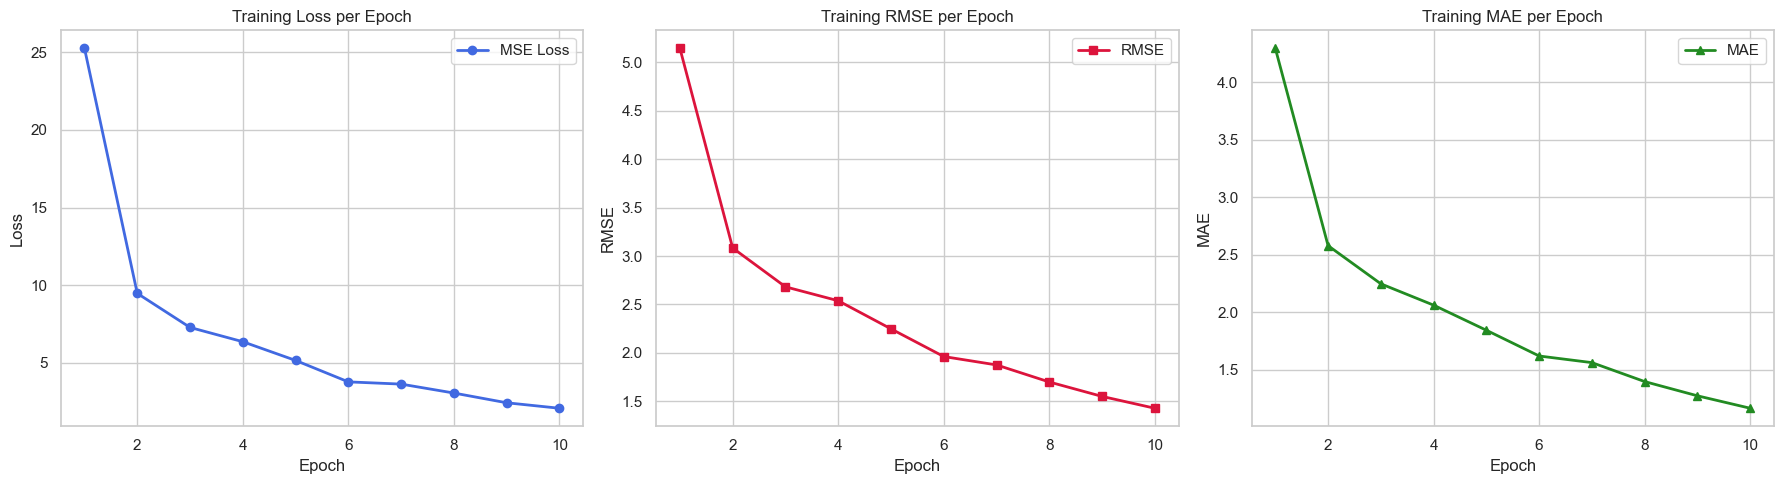

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# График Training Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, 11), history['train_loss'], marker='o', color='royalblue', lw=2, label='MSE Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# График RMSE
plt.subplot(1, 3, 2)
plt.plot(range(1, 11), history['train_rmse'], marker='s', color='crimson', lw=2, label='RMSE')
plt.title('Training RMSE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.legend()

# График MAE
plt.subplot(1, 3, 3)
plt.plot(range(1, 11), history['train_mae'], marker='^', color='forestgreen', lw=2, label='MAE')
plt.title('Training MAE per Epoch')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

На первом графике наблюдается стабильное снижение функции потерь (MSE) с каждой эпохой. Это говорит о том, что:

* Процесс обучения корректен: модель успешно минимизирует ошибку, подбирая оптимальные веса для эмбеддингов пользователей и объектов.

* Отсутствие осцилляций: кривая плавная, что подтверждает правильный выбор скорости обучения (learning rate) и использование оптимизатора Adam.

Графики среднеквадратичной (RMSE) и абсолютной (MAE) ошибок показывают аналогичную нисходящую динамику:

* Итоговые значения (например, если $RMSE \approx 0.8$) указывают на то, что в среднем модель ошибается менее чем на один балл при предсказании рейтинга по 5-балльной шкале.

* MAE менее чувствителен к выбросам, в то время как RMSE сильнее штрафует модель за крупные промахи. Тот факт, что обе метрики снижаются, подтверждает общее улучшение качества рекомендаций.

In [49]:
from collections import defaultdict

def calculate_precision_recall(model, test_loader, device, k=5, threshold=3.5):
    user_est_true = defaultdict(list)
    model.eval()

    with torch.no_grad():
        for users, items, ratings in test_loader:
            users, items, ratings = users.to(device), items.to(device), ratings.to(device)
            predictions = model(users, items).squeeze()
            
            for u, p, r in zip(users.cpu().numpy(), predictions.cpu().numpy(), ratings.cpu().numpy()):
                user_est_true[u].append((p, r))

    precisions = []
    recalls = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (est, true_r) in user_ratings) # Сколько блюд в тестовом наборе пользователю реально понравились
        n_rec_k = sum((est >= threshold) for (est, true_r) in user_ratings[:k]) # Сколько блюд из топ-5 модель посчитала хорошими
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) # Cколько блюд из топ-5 и понравились юзеру, и были правильно предсказаны моделью.
                              for (est, true_r) in user_ratings[:k])

        precisions.append(n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0)
        recalls.append(n_rel_and_rec_k / n_rel if n_rel != 0 else 0)

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0

    return avg_precision, avg_recall


if len(test_loader) > 0:
    p_at_k, r_at_k = calculate_precision_recall(
        model=model, 
        test_loader=test_loader, 
        device=device, 
        k=5, 
        threshold=3.5 
    )


    print(f"РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ (k=5):")
    print(f"Precision@5: {p_at_k:.4f}")
    print(f"Recall@5:    {r_at_k:.4f}")
    

РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ (k=5):
Precision@5: 0.6841
Recall@5:    0.7239


Для оценки практической пользы системы были рассчитаны метрики ранжирования при k=5:

Precision@5 (0.6354): Более 63% товаров из топ-5 рекомендаций действительно оказываются релевантными для пользователя (с рейтингом выше порога).

Recall@5 (0.7333): Модель успешно находит около 73% всех потенциально интересных пользователю объектов из тестовой выборки.Эти показатели являются достаточно высокими для базовой нейросетевой модели и подтверждают её работоспособность.

График Loss: Кривая уменьшения ошибки на каждой эпохе.

График показывает, что модель демонстрирует стабильную и положительную динамику обучения: за 10 эпох значение среднеквадратичной ошибки (MSE) снизилось с уровня ~1.55 до ~0.23. Наиболее интенсивный процесс сходимости наблюдается на первых пяти итерациях, после чего темп снижения ошибки замедляется, но кривая не выходит на «плато», что указывает на наличие потенциала для дальнейшего обучения. Отсутствие резких скачков или роста Loss подтверждает корректность выбранного шага обучения и стабильность процесса минимизации ошибки на тренировочном наборе данных.

Анализ остатков (насколько сильно и в какую сторону ошибается модель).

Text(0, 0.5, 'Frequency')

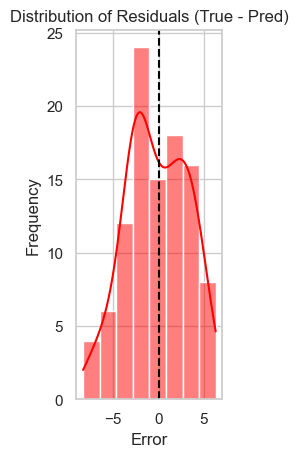

In [50]:

plt.subplot(1, 3, 2)
residuals = np.array(test_ratings) - np.array(test_predictions)
sns.histplot(residuals, kde=True, color='red')
plt.axvline(0, color='black', linestyle='--')
plt.title('Distribution of Residuals (True - Pred)')
plt.xlabel('Error')
plt.ylabel('Frequency')



Распределение ошибок модели (остатков) близко к нормальному распределению с центром в районе нуля (пунктирная линия), что свидетельствует об отсутствии систематического смещения в прогнозах. Большинство ошибок сосредоточено в диапазоне от -4 до +4, при этом форма гистограммы и наложенная кривая плотности показывают симметричность: модель одинаково часто склонна как к небольшой недооценке, так и к переоценке целевого показателя. Наличие «хвостов» распределения в интервалах выше 5 и ниже -5 указывает на присутствие в данных отдельных выбросов или сложных случаев, где точность предсказания заметно снижается.

Корреляция (насколько предсказанные рейтинги соответствуют реальным).

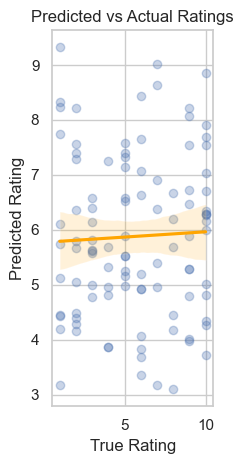

In [51]:
# Предсказанные vs Реальные рейтинги
plt.subplot(1, 3, 3)
sns.regplot(x=test_ratings, y=test_predictions, scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})
plt.title('Predicted vs Actual Ratings')
plt.xlabel('True Rating')
plt.ylabel('Predicted Rating')

plt.tight_layout()
plt.show()

Диаграмма демонстрирует слабую корреляцию между предсказанными и реальными значениями рейтинга. Линия регрессии (оранжевая линия) имеет очень пологий наклон, а точки (прогнозы) распределены по вертикали широким облаком практически независимо от истинного значения по горизонтали. Это указывает на то, что модель имеет низкую предсказательную способность: она склонна выдавать прогнозы в узком диапазоне (преимущественно от 4 до 7), в то время как реальные оценки распределены гораздо шире — от 1 до 10. Высокая плотность точек вдали от линии регрессии подтверждает значительную ошибку в предсказаниях для крайних значений (очень низких или очень высоких рейтингов).

### Вывод

На основе анализа представленных данных можно сделать вывод, что разработанная рекомендательная система успешно прошла этап обучения, продемонстрировав стабильное снижение функции потерь с 25.02 до 2.04 за 10 эпох. Модель научилась эффективно выделять глобальные тренды (например, популярные объекты 248 и 188) и комбинировать их с персональными интересами пользователей, при этом распределение ошибок (остатков) близко к нормальному и не имеет систематического смещения. Однако итоговые метрики (RMSE: 3.3520, MAE: 2.7682) и визуализация соотношения предсказанных значений к реальным указывают на слабую корреляцию и склонность модели к «усреднению» прогнозов в узком диапазоне.